# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle
import numpy as np
import csv

data_folder = 'data/'
training_file = 'train.p'
validation_file = 'valid.p'
testing_file = 'test.p'
fake_data_file = 'fake_data.p'

model_file = './traffic_sign_classifier_model.ckpt'
sign_names_file = './signnames.csv'

with open(data_folder + training_file, mode='rb') as f:
    train = pickle.load(f)
with open(data_folder + validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(data_folder + testing_file, mode='rb') as f:
    test = pickle.load(f)   
with open(data_folder + fake_data_file, mode='rb') as f:
    fake_data = pickle.load(f)
    
# Load CSV data
sign_name_lookup = dict()
with open(sign_names_file, newline='') as csvfile:
    sign_names_reader = csv.reader(csvfile)
    for row in sign_names_reader:
        sign_name_lookup[row[0]] = row[1]

X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']
X_fake_data, y_fake_data = fake_data['features'], fake_data['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [2]:
import numpy as np

n_train = len(X_train)
n_test = len(X_test)
n_validation = len(X_valid)
n_fake_data = len(X_fake_data)
image_shape = X_train[0].shape
n_classes = len(np.unique(y_train))

print("[Original (unaugmented) dataset statistics]")
print("Training examples in original dataset =", n_train)
print("Training examples in augmented dataset =", n_fake_data)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

[Original (unaugmented) dataset statistics]
Training examples in original dataset = 34799
Training examples in augmented dataset = 72701
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

<Container object of 43 artists>

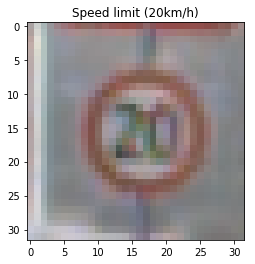

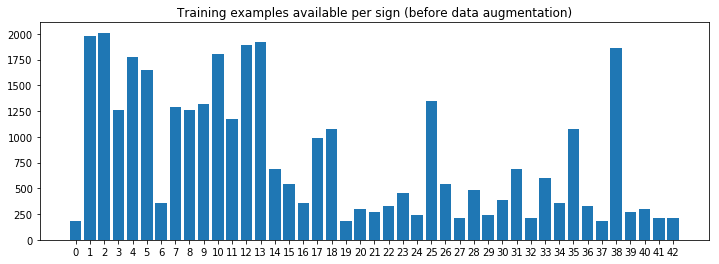

In [3]:
import matplotlib.pyplot as plt
import random
%matplotlib inline

def random_image_for_sign_id(sign_id):
    skipcount = random.randint(1,150)
    for z in range(0, len(y_train)):
        if y_train[z] == sign_id:
            skipcount = skipcount - 1
            if skipcount <= 0:
                break
    return X_train[z]

# Show a random image from the training dataset for a given sign ID
sign_id = 0
image = random_image_for_sign_id(sign_id)
plt.figure()
plt.title(sign_name_lookup[str(sign_id)])
plt.imshow(image.squeeze())

# Show training examples available per sign id
sign_ids, sign_counts = np.unique(y_train, return_counts=True)
plt.figure(figsize=(12,4))
plt.title("Training examples available per sign (before data augmentation)")
plt.xticks(sign_ids)
plt.bar(sign_ids, sign_counts)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Pre-process the Data Set (normalization, grayscale, etc.)

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [4]:
### Helper functions for image manipulation
### Both for generating perturbations, and also for preprocessing images
###
### General reference: http://www.scipy-lectures.org/advanced/image_processing/
### Reference for perturbation algorithms: https://fsix.github.io/mnist/Perturbing.html
### Reference for scaling while maintaining shape: http://stackoverflow.com/questions/37119071/scipy-rotate-and-zoom-an-image-without-changing-its-dimensions
### Reference for adjusting image brightness: http://stackoverflow.com/questions/32609098/how-to-fast-change-image-brightness-with-python-opencv
### Reference for histogram equalization: http://docs.opencv.org/3.1.0/d5/daf/tutorial_py_histogram_equalization.html

import matplotlib.pyplot as plt
%matplotlib inline

import scipy.ndimage as ndimage
import scipy.misc as misc
import numpy.random as random
import cv2 as opencv
import pickle

def random_perspective_transform(image):    
    distortion = 5
    x1 = random.randint(0 - distortion, distortion)
    y1 = random.randint(0 - distortion, distortion)
    x2 = image.shape[1] + random.randint(0 - distortion, distortion)
    y2 = random.randint(0 - distortion, distortion)
    x3 = random.randint(0 - distortion, distortion)
    y3 = image.shape[0] + random.randint(0 - distortion, distortion)
    x4 = image.shape[1] + random.randint(0 - distortion, distortion)
    y4 = image.shape[0] + random.randint(0 - distortion, distortion)
    
    pts1 = np.float32([[x1,y1],[x2,y2],[x3,y3],[x4,y4]])
    pts2 = np.float32([[0,0],[32,0],[0,32],[32,32]])
    
    M = opencv.getPerspectiveTransform(pts1,pts2)
    output = opencv.warpPerspective(image,M,(32,32))
    return output

def random_rotate(image):
    distortion = random.randint(-15, 15)
    return ndimage.rotate(image, distortion, reshape=False)

def random_scale(image):   
    def clipped_zoom(img, zoom_factor, **kwargs):
        h, w = img.shape[:2]
        zh = int(np.round(zoom_factor * h))
        zw = int(np.round(zoom_factor * w))
        zoom_tuple = (zoom_factor,) * 2 + (1,) * (img.ndim - 2)
        
        if zoom_factor < 1:
            top = (h - zh) // 2
            left = (w - zw) // 2
            out = np.zeros_like(img)
            out[top:top+zh, left:left+zw] = ndimage.zoom(img, zoom_tuple , **kwargs)
        elif zoom_factor > 1:
            top = (zh - h) // 2
            left = (zw - w) // 2
            out = ndimage.zoom(img[top:top+zh, left:left+zw], zoom_tuple, **kwargs)
            
            trim_top = ((out.shape[0] - h) // 2)
            trim_left = ((out.shape[1] - w) // 2)
            out = out[trim_top:trim_top+h, trim_left:trim_left+w]
        else:
            out = img
        return out
    
    distortion = random.uniform(0.8, 1.2)
    return clipped_zoom(image, distortion)

def random_brightness(image):
    hsv = opencv.cvtColor(image, opencv.COLOR_BGR2HSV)
    maxlimit = np.amax(hsv[:,:,2])
    minlimit = np.amin(hsv[:,:,2])
    distortion = random.randint(-50, 50)
    safe_brightness = 0
    if distortion > 0:
        safe_brightness = min(255 - maxlimit, distortion)
    else:
        safe_brightness = max(0 - minlimit, distortion)
    hsv[:,:,2] += np.uint8(safe_brightness)
    image = opencv.cvtColor(hsv, opencv.COLOR_HSV2BGR)
    return image

def random_blur(image):
    return ndimage.gaussian_filter(image, sigma=random.uniform(0.0, 0.3))

def random_shift(image):
    distortion = random.randint(-2, 2)
    return ndimage.interpolation.shift(image, (distortion, distortion, 0))

# We need this for equalizing histograms
clahe = opencv.createCLAHE(clipLimit=2.0, tileGridSize=(4,4))
def greyscale(image):
    greyscale_image = opencv.cvtColor(image, opencv.COLOR_RGB2GRAY)
    equalized_hist = clahe.apply(greyscale_image.squeeze())
    equalized_hist = equalized_hist.reshape(equalized_hist.shape + (1,))
    return equalized_hist

def normalize(image):
    normalized_image = np.copy(image)
    normalized_image = opencv.normalize(image, dst=normalized_image, alpha=-1, beta=1, norm_type=opencv.NORM_MINMAX, dtype=opencv.CV_32F)
    normalized_image = normalized_image.reshape(normalized_image.shape + (1,))
    return normalized_image

def preprocess(image):
    return normalize(greyscale(image))

def create_distorted_variant(image):
    image = random_brightness(image)
        
    if (random.randint(0, 1) == 0):
        image = random_scale(image)
    else:
        image = random_perspective_transform(image)

    if (random.randint(0, 1) == 0):
        image = random_shift(image)
        
    if (random.randint(0, 1) == 0):
        image = random_rotate(image)
        
    if (random.randint(0, 1) == 0):
        image = random_blur(image)        
    return image
    
# Looks at the number of training examples for each traffic sign,
# and augments it with supplementary fake data so that there are
# enough training examples for all signs
def build_augmented_dataset():
    
    with open(data_folder + training_file, mode='rb') as f:
        original_data = pickle.load(f)
    
    train_features, train_labels = original_data['features'], original_data['labels']
    target_training_size_per_sign = 2500
    
    # Figure out the number of training samples for each sign that we have
    # We want to generate enough fake data so that all signs have the
    # same amount of training data
    sign_ids, sign_counts = np.unique(train_labels, return_counts=True)
    counts = dict(zip(sign_ids, sign_counts))
    
    fake_feature_data = []
    fake_label_data = []
    
    for sign_id, sign_count in counts.items():
        counts[sign_id] = dict()
        counts[sign_id]['count'] = sign_count
        counts[sign_id]['variants_needed'] = target_training_size_per_sign - sign_count
        counts[sign_id]['indices'] = []

    for x in range(0, len(train_features)):
        curr_feature = train_features[x]
        curr_label = train_labels[x]
        counts[curr_label]['indices'].append(x)

    # We now have a dict of the gaps we need to fill (both their indices, and the counts)
    for sign_id, details in counts.items():
        variants_needed = details['variants_needed']
        source_image_indices = details['indices']
        
        print()
        print("Generating variants for sign: ", sign_id, "...")
        current_source_image = 0
        for x in range(0, variants_needed):
            source_image_index = source_image_indices[current_source_image]
            source_image = train_features[source_image_index]            
            
            new_image = create_distorted_variant(source_image)
            fake_feature_data.append(new_image)
            fake_label_data.append(sign_id)
            
            if current_source_image > 0 and current_source_image % 500 == 0:
                print("  ", x, "/", variants_needed)
            
            current_source_image = (current_source_image + 1) % len(details['indices'])
            
    fake_data = { 'features': fake_feature_data, 'labels': fake_label_data }
    with open(data_folder + fake_data_file, 'wb') as output:
        pickle.dump(fake_data, output, pickle.HIGHEST_PROTOCOL)
    print("Saving complete.")

# Mix up the test and training sets and re-split them
def rebuild_train_and_test(X_train, y_train, X_test, y_test):
    X_train, X_test, y_train, y_test = train_test_split(np.concatenate([X_train, X_test]), np.concatenate([y_train, y_test]), test_size=0.3)
    return X_train, y_train, X_test, y_test


# Uncomment this line to build the fake dataset
#
# build_augmented_dataset()
#

/home/cerebro/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


[New (augmented) dataset statistics]
Training examples in original dataset = 84091
Number of testing examples = 36039
Number of classes in Training set = 43
Number of classes in Test set = 43


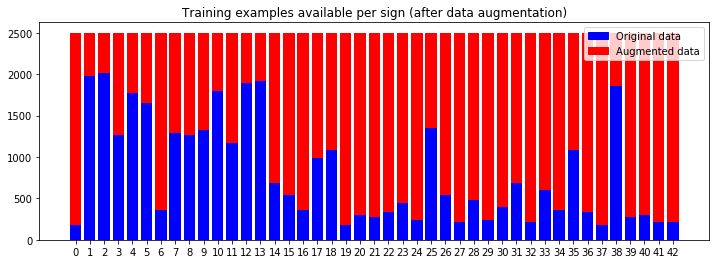

In [5]:
import matplotlib.patches as mpatches
from sklearn.cross_validation import train_test_split

# Show training examples available per sign id vs fake data
sign_ids, sign_counts = np.unique(y_train, return_counts=True)
fake_sign_ids, fake_sign_counts = np.unique(y_fake_data, return_counts=True)

plt.figure(figsize=(12,4))
plt.title("Training examples available per sign (after data augmentation)")
plt.xticks(sign_ids)

red_patch = mpatches.Patch(color='red', label='Augmented data')
blue_patch = mpatches.Patch(color='blue', label='Original data')
plt.legend(handles=[blue_patch, red_patch])
plt.bar(sign_ids, sign_counts, color='blue')
if len(fake_sign_ids) > 0:
    plt.bar(fake_sign_ids, fake_sign_counts, color='red', bottom=sign_counts)


# Merge the augmented data with the training data
if len(X_fake_data) > 0:
    X_train = np.concatenate([X_train, X_fake_data, X_test])
    y_train = np.concatenate([y_train, y_fake_data, y_test])

    X_fake_data = []
    y_fake_data = []

    # Rebuild our training and test sets by sampling randomly
    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3)


# We only want to preprocess once
# Unprocessed data will have a depth of 3
# processed data will have a depth of 1
if X_train[0].shape[2] != 1:
    X_train = [preprocess(x) for x in X_train]
    X_test = [preprocess(x) for x in X_test]
    X_valid = [preprocess(x) for x in X_valid]


# Recalculate and report summary
n_train = len(X_train)
n_test = len(X_test)
n_classes = len(np.unique(y_train))
n_classes_test = len(np.unique(y_test))

print("[New (augmented) dataset statistics]")
print("Training examples in original dataset =", n_train)
print("Number of testing examples =", n_test)
print("Number of classes in Training set =", n_classes)
print("Number of classes in Test set =", n_classes)


### Model Architecture

In [6]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten

# Note on coding practice:
# We need some of the variables here for our L2 Regularization later

# Leaving variables out in the open is bad practice, and in the Tensorflow docs
# there is a section on variable scoping / sharing that lets us write better code.
# Unfortunately, I have not figured out how to use that properly yet. 
# For now I am making this tradeoff.

# mean and stddev used for tf.truncated_normal
mu = 0
sigma = 0.1

cv1_filter_weights = tf.Variable(tf.truncated_normal([5, 5, 1, 12], mean=mu, stddev=sigma))
cv1_filter_bias = tf.Variable(tf.truncated_normal([12], mean=mu, stddev=sigma))
cv1_stride = [1, 1, 1, 1]
cv1_padding = 'VALID'

cv2_filter_weights = tf.Variable(tf.truncated_normal([5, 5, 12, 18], mean=mu, stddev=sigma))
cv2_filter_bias = tf.Variable(tf.truncated_normal([18], mean=mu, stddev=sigma))
cv2_stride = [1, 1, 1, 1]
cv2_padding = 'VALID'

cv2_pool_ksize = [1, 2, 2, 1]
cv2_pool_kstrides = [1, 2, 2, 1]
cv2_pool_kpadding = 'VALID'

cv3_filter_weights = tf.Variable(tf.truncated_normal([5, 5, 18, 24], mean=mu, stddev=sigma))
cv3_filter_bias = tf.Variable(tf.truncated_normal([24], mean=mu, stddev=sigma))
cv3_stride = [1, 1, 1, 1]
cv3_padding = 'VALID'
cv3_pool_ksize = [1, 2, 2, 1]
cv3_pool_kstrides = [1, 2, 2, 1]
cv3_pool_kpadding = 'VALID'

fc4_weights = tf.Variable(tf.truncated_normal([2976, 250], mean=mu, stddev=sigma))
fc4_bias = tf.Variable(tf.truncated_normal([250], mean=mu, stddev=sigma))

fc5_weights = tf.Variable(tf.truncated_normal([250, 100], mean=mu, stddev=sigma))
fc5_bias = tf.Variable(tf.truncated_normal([100], mean=mu, stddev=sigma))

fc6_weights = tf.Variable(tf.truncated_normal([100, 43], mean=mu, stddev=sigma))
fc6_bias = tf.Variable(tf.truncated_normal([43], mean=mu, stddev=sigma))   

keep_prob = tf.placeholder(tf.float32)

cv2_pooling = tf.placeholder(tf.float32)
cv3_pooling = tf.placeholder(tf.float32)
fc4_activation = tf.placeholder(tf.float32)
fc5_activation = tf.placeholder(tf.float32)
fc6_activation = tf.placeholder(tf.float32)

def TrafficSignConvNet(x):
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x12.
    cv1 = tf.nn.conv2d(x, cv1_filter_weights, strides=cv1_stride, padding=cv1_padding)
    cv1 = tf.nn.bias_add(cv1, cv1_filter_bias)
    
    # Activation.
    cv1_activation = tf.nn.relu(cv1)

    # Layer 2: Convolutional. Input = 28x28x12. Output = 24x24x18.
    cv2 = tf.nn.conv2d(cv1_activation, cv2_filter_weights, strides=cv2_stride, padding=cv2_padding)
    cv2 = tf.nn.bias_add(cv2, cv2_filter_bias)
    
    # Activation.
    cv2_activation = tf.nn.relu(cv2)
    
    # Pooling. Input = 24x24x18. Output = 12x12x18
    cv2_pooling = tf.nn.max_pool(cv2_activation, cv2_pool_ksize, cv2_pool_kstrides, cv2_pool_kpadding)
    
    # Flatten. Input = 12x12x18. Output = 2592
    cv2_flat = flatten(cv2_pooling)

    # Layer 3: Convolutional. Output = 8x8x24.
    cv3 = tf.nn.conv2d(cv2_pooling, cv3_filter_weights, cv3_stride, cv3_padding)
    cv3 = tf.nn.bias_add(cv3, cv3_filter_bias)
    
    # Activation.
    cv3_activation = tf.nn.relu(cv3)

    # Pooling. Input = 8x8x24. Output = 4x4x24
    cv3_pooling = tf.nn.max_pool(cv3_activation, cv3_pool_ksize, cv3_pool_kstrides, cv3_pool_kpadding)

    # Dropout
    cv3_output = tf.nn.dropout(cv3_pooling, keep_prob)
    
    # Flatten. Input = 4x4x24. Output = 384
    cv3_flat = flatten(cv3_output)
    
    # Merge output from stage 1 & 2 pooling into final layer
    # (As per the Semmanet and LeCun paper)
    # Input = 2592 + 384 = 2976
    merged_input = tf.concat([cv2_flat, cv3_flat], 1)
    
    # Layer 4: Fully Connected. Input = 2976. Output = 250.
    fc4 = tf.add(tf.matmul(merged_input, fc4_weights), fc4_bias)

    # Activation.
    fc4_activation = tf.nn.relu(fc4)
    
    # Layer 5: Fully Connected. Input = 250. Output = 100.
    fc5 = tf.add(tf.matmul(fc4_activation, fc5_weights), fc5_bias)

    # Activation.
    fc5_activation = tf.nn.relu(fc5)
    
    # Layer 6: Fully Connected. Input = 100. Output = 43.
    logits = tf.add(tf.matmul(fc5_activation, fc6_weights), fc6_bias)
    
    return logits

# One-hot encode our labels
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [7]:
# Training pipeline
from sklearn.utils import shuffle

rate = 0.001

logits = TrafficSignConvNet(x)

# L2 Regularization
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y)
l2_loss = (rate * tf.nn.l2_loss(cv1_filter_weights) +
           rate * tf.nn.l2_loss(cv3_filter_weights) +
           rate * tf.nn.l2_loss(fc4_weights) +
           rate * tf.nn.l2_loss(fc5_weights) +
           rate * tf.nn.l2_loss(fc6_weights))

l2_regularization = cross_entropy + l2_loss
                                     
loss_operation = tf.reduce_mean(l2_regularization)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

# Model evaluation
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

EPOCHS = 10
BATCH_SIZE = 64

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    
    current_epoch = 0
    remaining_epochs = EPOCHS
    current_max = 0
    while remaining_epochs >= 0:
        current_epoch = current_epoch + 1
        
        X_train, y_train, X_test, y_test = rebuild_train_and_test(X_train, y_train, X_test, y_test)

        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})

        validation_accuracy = evaluate(X_valid, y_valid)
        test_accuracy = evaluate(X_test, y_test)
        train_accuracy = evaluate(X_train, y_train)
        print("EPOCH {}, Remaining: {}".format(current_epoch, remaining_epochs))
        print("Accuracy against Training set = {:.3f}".format(train_accuracy))
        print("Accuracy against Test set = {:.3f}".format(test_accuracy))   
        print("Accuracy against Validation set = {:.3f}".format(validation_accuracy))   
        
        # If we are making progress, add another 3 epochs to our run 
        # to give the training another chance to get improve
        if (validation_accuracy > current_max):
            current_max = validation_accuracy
            remaining_epochs += 3
            print("(New maximum! +3 Epochs)")

        remaining_epochs = remaining_epochs - 1
        print()
        
    saver.save(sess, model_file)
    
    print("Model saved")
    
    sess.close()


Training...

EPOCH 1, Remaining: 10
Accuracy against Training set = 0.965
Accuracy against Test set = 0.954
Accuracy against Validation set = 0.972
(New maximum! +3 Epochs)

EPOCH 2, Remaining: 12
Accuracy against Training set = 0.982
Accuracy against Test set = 0.974
Accuracy against Validation set = 0.976
(New maximum! +3 Epochs)

EPOCH 3, Remaining: 14
Accuracy against Training set = 0.986
Accuracy against Test set = 0.978
Accuracy against Validation set = 0.980
(New maximum! +3 Epochs)

EPOCH 4, Remaining: 16
Accuracy against Training set = 0.982
Accuracy against Test set = 0.975
Accuracy against Validation set = 0.981
(New maximum! +3 Epochs)

EPOCH 5, Remaining: 18
Accuracy against Training set = 0.983
Accuracy against Test set = 0.976
Accuracy against Validation set = 0.978

EPOCH 6, Remaining: 17
Accuracy against Training set = 0.989
Accuracy against Test set = 0.984
Accuracy against Validation set = 0.978

EPOCH 7, Remaining: 16
Accuracy against Training set = 0.993
Accuracy a

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

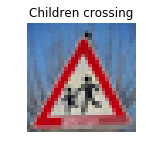

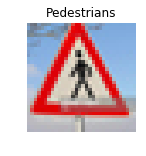

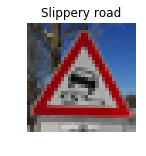

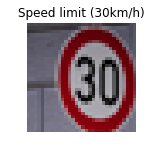

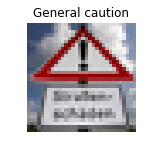

In [8]:
test_image_folder = 'testsign/'

test_image_list = ['kinder.jpg',
                 'pedestrians.jpg',
                 'snow.jpg',
                 'speedlimit.jpg',
                 'generalcaution.jpg']

test_image_labels = [28, 27, 23, 1, 18]

test_images = []
test_images_preprocessed = []

# Pre-process images
for x in range(0, len(test_image_list)):
    file_name = test_image_list[x]
    current_image = plt.imread(test_image_folder + file_name)
    plt.figure(figsize=(2, 2))
    plt.title(sign_name_lookup[str(test_image_labels[x])])
    plt.axis('off')
    plt.imshow(current_image)
    
    test_images.append(current_image)
    test_images_preprocessed.append(preprocess(current_image))


### Predict the Sign Type for Each Image

In [9]:
saver = tf.train.Saver()

# Variables
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)

# Operations
logits = TrafficSignConvNet(x)
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, model_file)
    softmax_output = sess.run(tf.nn.softmax(logits), feed_dict={ x: test_images_preprocessed, y: test_image_labels, keep_prob: 1.0})
    predictions = sess.run(tf.argmax(softmax_output, 1))
    accuracy = sess.run(accuracy_operation, feed_dict={ x: test_images_preprocessed, y: test_image_labels, keep_prob: 1.0 })

    print("[Predictions]")
    for idx in range(0, len(predictions)):
        indicator = '<- Correct!' if predictions[idx] == test_image_labels[idx] else ''
        print ('{:>2}. Actual: ({:>2}) {:<20}   Predicted: ({:>2}) {:<20} {} '.format(idx + 1, test_image_labels[idx], sign_name_lookup[str(test_image_labels[idx])], predictions[idx], sign_name_lookup[str(predictions[idx])], indicator))

    print()
    print('Prediction accuracy: {:.2f}%'.format(accuracy * 100))
        
    sess.close()

[Predictions]
 1. Actual: (28) Children crossing      Predicted: (28) Children crossing    <- Correct! 
 2. Actual: (27) Pedestrians            Predicted: (27) Pedestrians          <- Correct! 
 3. Actual: (23) Slippery road          Predicted: (23) Slippery road        <- Correct! 
 4. Actual: ( 1) Speed limit (30km/h)   Predicted: ( 1) Speed limit (30km/h) <- Correct! 
 5. Actual: (18) General caution        Predicted: (23) Slippery road         

Prediction accuracy: 80.00%


### Analyze Performance

In [111]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

# Note: The performance has been analyzed in the previous cell

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tk.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

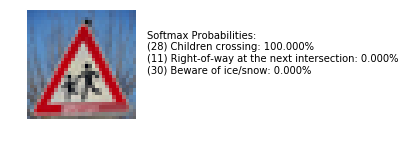

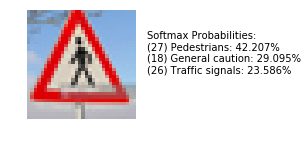

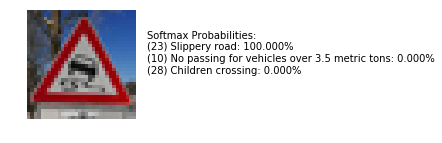

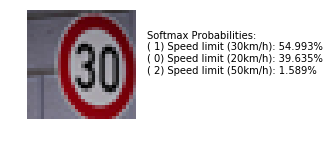

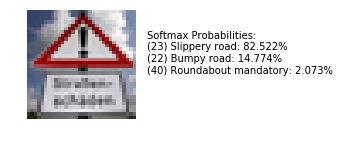

In [10]:
# Get the top 5 softmax_outputs and display them
with tf.Session() as sess:
    top_k = sess.run(tf.nn.top_k(tf.constant(softmax_output), k=5))
    probabilities = top_k.values
    indices = top_k.indices

    for x in range(0, len(test_images)):
        plt.figure(figsize=(2, 2))
        description = "Softmax Probabilities:\n({:>2}) {}: {:.3f}%\n({:>2}) {}: {:.3f}%\n({:>2}) {}: {:.3f}%".format(indices[x][0], sign_name_lookup[str(indices[x][0])], probabilities[x][0] * 100,
                                                                                          indices[x][1], sign_name_lookup[str(indices[x][1])], probabilities[x][1] * 100,
                                                                                          indices[x][2], sign_name_lookup[str(indices[x][2])], probabilities[x][2] * 100)
        plt.text (35, 18, description)
        plt.axis('off')
        plt.imshow(test_images[x])
        
    sess.close()
    

---

## Step 4: Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [57]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it maybe having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess, feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")


### Question 9

Discuss how you used the visual output of your trained network's feature maps to show that it had learned to look for interesting characteristics in traffic sign images


**Answer:**

Unfortunately, as I am still getting used to Tensorflow, I was not able to get the outputFeatureMaps function to work. I ended up prioritizing the other sections to ensure a properly completed project. I did find some documentation on variable sharing which might help me, but due to time constraints, I will submit the project as is for now. Will play around and have fun with this another time. :)

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 